In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as pickle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler


In [31]:
df = pd.read_csv('../../data/cleanData/OED_2.csv')
df.head()

,Unnamed: 0,major_department,year,music_genre,living,humour,friend_qualities,personal_qualities,sports,friday_night,school_balance,entertainment_genre
0,0,1,4,9,0,3,"Trustworthy, Social Intelligence, Humour","Understanding, Supportive, Loyalty",1,2,0,2
1,1,2,4,6,0,0,"Trustworthy, Kindness, Loyalty","Trustworthy, Kindness, Loyalty",0,0,0,1
2,2,1,4,6,0,3,"Ambition, Kindness, Understanding","Ambition, Kindness, Leadership",0,1,1,7
3,3,1,4,3,0,1,"Kindness, Understanding, Supportive","Kindness, Understanding, Social Intelligence",0,2,1,5
4,4,1,4,1,0,1,"Trustworthy, Understanding, Humour","Ambition, Supportive, Loyalty",1,3,1,1


In [61]:
# This keeps breaking 

# # Instantiating the Scaler
# scaler = MinMaxScaler()
# # Scaling the categories then replacing the old values
# df = df[['personal_qualities']].join(
#               pd.DataFrame(
#           scaler.fit_transform(
#                                df.drop('personal_qualities',axis=1)), 
#                                columns=df.columns[1:], 
#                                index=df.index))

## --- Vectorization ---

This cell has the code for instantiating the Vectorizer, experimenting with both

Vectorization is transforming text to a vector. Takes every unique word and makes it its own column that tracks the count number


In [32]:
# Implementing CountVectorizer. 

vectorizer = CountVectorizer()
#vectorizer = TfidfVectorizer()

# Fitting the vectorizer to the Bios
x = vectorizer.fit_transform(df['personal_qualities'])

# Creating a new DF that contains the vectorized words
df_wrds = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names())

# Concating the words DF with the original DF
new_df = pd.concat([df, df_wrds], axis=1)

new_df.drop('personal_qualities', axis=1, inplace=True)
new_df.drop('friend_qualities', axis=1, inplace=True)

In [33]:
new_df.head()

,Unnamed: 0,major_department,year,music_genre,living,humour,sports,friday_night,school_balance,entertainment_genre,...,fairness,humour,intelligence,kindness,leadership,loyalty,social,supportive,trustworthy,understanding
0,0,1,4,9,0,3,1,2,0,2,...,0,0,0,0,0,1,0,1,0,1
1,1,2,4,6,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,1,0
2,2,1,4,6,0,3,0,1,1,7,...,0,0,0,1,1,0,0,0,0,0
3,3,1,4,3,0,1,0,2,1,5,...,0,0,1,1,0,0,1,0,0,1
4,4,1,4,1,0,1,1,3,1,1,...,0,0,0,0,0,1,0,1,0,0


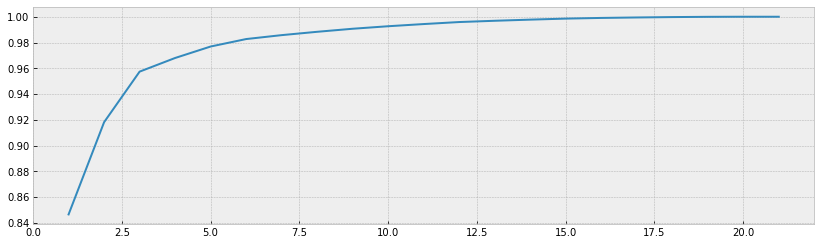

Number features: 2
Total Variance Explained: 0.9573990350403173
0.9181546689834384


In [34]:
# Importing the library
from sklearn.decomposition import PCA

# Instantiating PCA
pca = PCA()

# Fitting and Transforming the DF
df_pca = pca.fit_transform(new_df)

# Plotting to determine how many features should the dataset be reduced to
plt.style.use("bmh")
plt.figure(figsize=(14,4))
plt.plot(range(1,new_df.shape[1]+1), pca.explained_variance_ratio_.cumsum())
plt.show()

# Finding the exact number of features that explain at least 95% of the variance in the dataset
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance>=.95])
n_to_reach_95 = new_df.shape[1] - n_over_95

# Printing out the number of features needed to retain 95% variance
print(f"Number features: {n_to_reach_95}\nTotal Variance Explained: {total_explained_variance[n_to_reach_95]}")

# Reducing the dataset to the number of features determined before
pca = PCA(n_components=n_to_reach_95)

# Fitting and transforming the dataset to the stated number of features and creating a new DF
df_pca = pca.fit_transform(new_df)

# Seeing the variance ratio that still remains after the dataset has been reduced
print(pca.explained_variance_ratio_.cumsum()[-1])

## -- Evaluation Metrics for Clustering --

Figuring out the optimal number of clusters using Silhouette Coef and the Davies-Bouldin Score. 

SC: higher the better, where 1 is the best and -1 is the worst. 

DB: lower the better

The cell below will generate a list of evaluation scores for all possible k values

In [22]:
# Setting the amount of clusters to test out
cluster_cnt = [i for i in range(2, 20, 1)]

# Establishing empty lists to store the scores for the evaluation metrics
s_scores = []

db_scores = []

# Looping through different iterations for the number of clusters
for i in cluster_cnt:
    
    # Hierarchical Agglomerative Clustering with different number of clusters
    hac = AgglomerativeClustering(n_clusters=i)
    
    hac.fit(df_pca)
    
    cluster_assignments = hac.labels_
    
    ## KMeans Clustering with different number of clusters
    #k_means = KMeans(n_clusters=i)
    
    #k_means.fit(df_pca)
    
    #cluster_assignments = k_means.predict(df_pca)
    
    # Appending the scores to the empty lists    
    s_scores.append(silhouette_score(df_pca, cluster_assignments))
    
    db_scores.append(davies_bouldin_score(df_pca, cluster_assignments))

## --- Plotting the scores ---

Max Value:
Cluster #    Cluster Score
2       0.531063

Min Value:
Cluster #     Cluster Score
18       0.337716


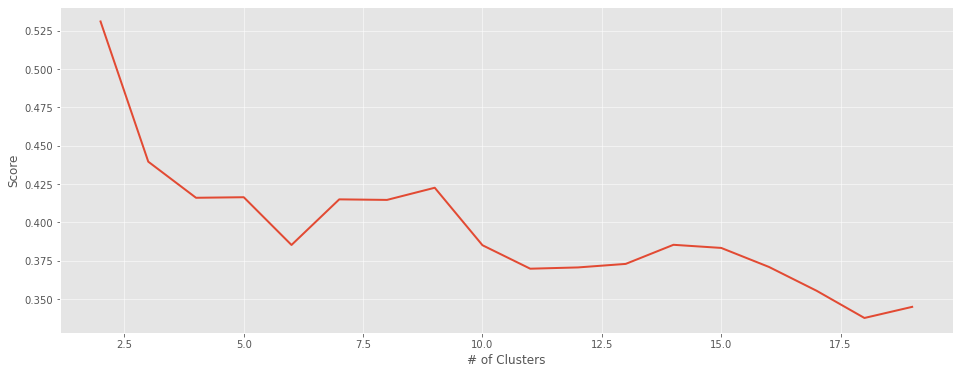

In [25]:
def plot_evaluation(y, x=cluster_cnt):
    """
    Plots the scores of a set evaluation metric. Prints out the max and min values of the evaluation scores.
    """
    
    # Creating a DataFrame for returning the max and min scores for each cluster
    df = pd.DataFrame(columns=['Cluster Score'], index=[i for i in range(2, len(y)+2)])
    df['Cluster Score'] = y
    
    print('Max Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].max()])
    print('\nMin Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].min()])
    
    # Plotting out the scores based on cluster count
    plt.figure(figsize=(16,6))
    plt.style.use('ggplot')
    plt.plot(x,y)
    plt.xlabel('# of Clusters')
    plt.ylabel('Score')
    plt.show()
    
# Running the function on the list of scores
plot_evaluation(s_scores)
# the higher the better (1 : best)


Max Value:
Cluster #    Cluster Score
4        0.81474

Min Value:
Cluster #     Cluster Score
18       0.493934


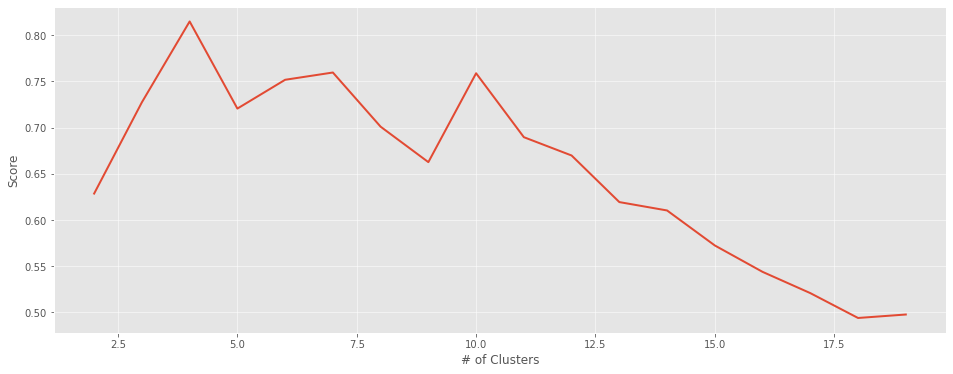

In [24]:
plot_evaluation(db_scores)
# the lower the better

## --- Running HAC ---

In [52]:
# Instantiating HAC
hac = AgglomerativeClustering(n_clusters=5)

# Fitting
hac.fit(df_pca)

scaler.fit(new_df)
# Getting cluster assignments
cluster_assignments = hac.labels_

# Unscaling the categories then replacing the scaled values
# df = df[['personal_qualities']].join(pd.DataFrame(scaler.inverse_transform(df.drop('personal_qualities', axis=1)), columns=df.columns[1:], index=df.index))

# Assigning the clusters to each profile
df['Cluster #'] = cluster_assignments

# Viewing the dating profiles with cluster assignments
df

,Unnamed: 0,major_department,year,music_genre,living,humour,friend_qualities,personal_qualities,sports,friday_night,school_balance,entertainment_genre,Cluster #
0,0,1,4,9,0,3,"Trustworthy, Social Intelligence, Humour","Understanding, Supportive, Loyalty",1,2,0,2,0
1,1,2,4,6,0,0,"Trustworthy, Kindness, Loyalty","Trustworthy, Kindness, Loyalty",0,0,0,1,0
2,2,1,4,6,0,3,"Ambition, Kindness, Understanding","Ambition, Kindness, Leadership",0,1,1,7,0
3,3,1,4,3,0,1,"Kindness, Understanding, Supportive","Kindness, Understanding, Social Intelligence",0,2,1,5,0
4,4,1,4,1,0,1,"Trustworthy, Understanding, Humour","Ambition, Supportive, Loyalty",1,3,1,1,0
5,5,1,3,1,0,1,"Ambition, Trustworthy, Humour","Ambition, Humour, Loyalty",0,2,1,3,0
6,6,2,4,1,0,2,"Ambition, Trustworthy, Supportive","Ambition, Fairness, Supportive",1,2,0,5,0
7,7,1,3,6,0,3,"Kindness, Supportive, Humour","Ambition, Leadership, Social Intelligence",1,0,1,8,0
8,8,2,4,4,0,3,"Kindness, Supportive, Humour","Kindness, Understanding, Supportive",0,2,0,1,0
9,9,0,4,4,0,1,"Trustworthy, Humour, Loyalty","Ambition, Fairness, Humour",1,0,0,2,0


## --- 5 clusters ---

In [60]:
rslt_df = df[df['Cluster #'] == 0]
rslt_df

# year mostly 4 (senior), mostly business  

,Unnamed: 0,major_department,year,music_genre,living,humour,friend_qualities,personal_qualities,sports,friday_night,school_balance,entertainment_genre,Cluster #
0,0,1,4,9,0,3,"Trustworthy, Social Intelligence, Humour","Understanding, Supportive, Loyalty",1,2,0,2,0
1,1,2,4,6,0,0,"Trustworthy, Kindness, Loyalty","Trustworthy, Kindness, Loyalty",0,0,0,1,0
2,2,1,4,6,0,3,"Ambition, Kindness, Understanding","Ambition, Kindness, Leadership",0,1,1,7,0
3,3,1,4,3,0,1,"Kindness, Understanding, Supportive","Kindness, Understanding, Social Intelligence",0,2,1,5,0
4,4,1,4,1,0,1,"Trustworthy, Understanding, Humour","Ambition, Supportive, Loyalty",1,3,1,1,0
5,5,1,3,1,0,1,"Ambition, Trustworthy, Humour","Ambition, Humour, Loyalty",0,2,1,3,0
6,6,2,4,1,0,2,"Ambition, Trustworthy, Supportive","Ambition, Fairness, Supportive",1,2,0,5,0
7,7,1,3,6,0,3,"Kindness, Supportive, Humour","Ambition, Leadership, Social Intelligence",1,0,1,8,0
8,8,2,4,4,0,3,"Kindness, Supportive, Humour","Kindness, Understanding, Supportive",0,2,0,1,0
9,9,0,4,4,0,1,"Trustworthy, Humour, Loyalty","Ambition, Fairness, Humour",1,0,0,2,0


In [53]:
rslt_df = df[df['Cluster #'] == 1]
rslt_df 


,Unnamed: 0,major_department,year,music_genre,living,humour,friend_qualities,personal_qualities,sports,friday_night,school_balance,entertainment_genre,Cluster #
21,21,1,2,1,0,2,"Fairness, Understanding, Supportive","Understanding, Supportive, Humour",0,2,2,1,1
22,22,1,4,6,0,0,"Leadership, Social Intelligence, Humour","Leadership, Social Intelligence, Humour",0,0,0,2,1
23,23,1,4,9,0,1,"Trustworthy, Supportive, Humour","Fairness, Understanding, Humour",1,2,0,2,1
24,24,1,4,0,0,1,"Ambition, Kindness, Supportive","Ambition, Understanding, Social Intelligence",1,2,0,1,1
25,25,1,4,5,0,1,"Understanding, Humour, Loyalty","Understanding, Humour, Loyalty",0,1,1,1,1


In [54]:
rslt_df = df[df['Cluster #'] == 2]
rslt_df 
# music usually > 5, humour = 3 mostly, entertainment, alot more kindness

,Unnamed: 0,major_department,year,music_genre,living,humour,friend_qualities,personal_qualities,sports,friday_night,school_balance,entertainment_genre,Cluster #
11,11,0,1,9,0,1,"Trustworthy, Kindness, Supportive","Kindness, Supportive, Loyalty",1,1,0,6,2
12,12,1,0,10,0,3,"Kindness, Social Intelligence, Humour","Social Intelligence, Humour, Loyalty",0,2,0,8,2
13,13,1,2,8,0,0,"Kindness, Supportive, Social Intelligence","Ambition, Kindness, Supportive",0,1,1,0,2
14,14,2,3,1,0,3,"Trustworthy, Humour, Loyalty","Kindness, Humour, Loyalty",1,0,0,1,2
15,15,1,4,6,0,3,"Fairness, Trustworthy, Loyalty","Ambition, Fairness, Understanding",1,2,0,0,2
16,16,1,4,11,0,2,"Kindness, Understanding, Supportive","Ambition, Understanding, Loyalty",1,2,2,6,2
17,17,2,3,7,0,3,"Trustworthy, Kindness, Supportive","Fairness, Kindness, Understanding",0,1,1,2,2
18,18,1,4,6,0,3,"Trustworthy, Understanding, Loyalty","Trustworthy, Understanding, Loyalty",0,1,0,2,2
19,19,2,4,5,0,3,"Trustworthy, Understanding, Social Intelligence","Ambition, Fairness, Kindness",0,2,0,8,2
20,20,1,1,6,0,3,"Trustworthy, Humour","Kindness, Supportive, Loyalty",1,0,0,4,2


In [55]:
rslt_df = df[df['Cluster #'] == 3]
rslt_df 

,Unnamed: 0,major_department,year,music_genre,living,humour,friend_qualities,personal_qualities,sports,friday_night,school_balance,entertainment_genre,Cluster #
30,30,2,2,4,0,0,"Trustworthy, Humour, Loyalty","Trustworthy, Humour, Loyalty",0,2,0,1,3
31,31,1,2,6,0,3,"Trustworthy, Kindness, Humour","Trustworthy, Humour, Loyalty",0,0,2,2,3
32,32,1,3,1,0,1,"Kindness, Understanding, Loyalty","Kindness, Understanding, Supportive",1,0,0,1,3
33,33,2,4,6,0,3,"Understanding, Social Intelligence, Humour","Ambition, Fairness, Humour",0,0,0,4,3
34,34,1,1,2,0,3,"Fairness, Trustworthy, Kindness, Social Intelligence, Loyalty","Ambition, Fairness, Trustworthy, Kindness, Understanding, Supportive, Leadership, Social Intelligence, Humour, Loyalty",1,3,1,3,3
35,35,1,2,6,1,0,"Trustworthy, Understanding, Social Intelligence","Ambition, Supportive, Social Intelligence",0,0,0,1,3
36,36,1,4,6,0,4,"Trustworthy, Supportive, Humour","Fairness, Understanding, Humour",0,2,0,4,3
37,37,1,1,4,0,3,"Trustworthy, Kindness, Humour","Kindness, Supportive, Humour",1,2,1,0,3


In [56]:
rslt_df = df[df['Cluster #'] == 4]
rslt_df 

# very close match of the qualities and entertainment

,Unnamed: 0,major_department,year,music_genre,living,humour,friend_qualities,personal_qualities,sports,friday_night,school_balance,entertainment_genre,Cluster #
26,26,1,4,6,0,3,"Trustworthy, Supportive, Humour","Ambition, Kindness, Humour",0,1,0,8,4
27,27,1,4,6,0,3,"Trustworthy, Supportive, Humour","Ambition, Kindness, Humour",0,1,0,8,4
28,28,1,4,6,0,3,"Trustworthy, Supportive, Humour","Ambition, Kindness, Humour",0,1,0,8,4
29,29,2,4,10,0,3,"Trustworthy, Supportive, Loyalty","Fairness, Kindness, Loyalty",1,1,0,1,4


## --- 3 clusters ---

In [ ]:
# Not the best because I personally din't see much difference in clusters

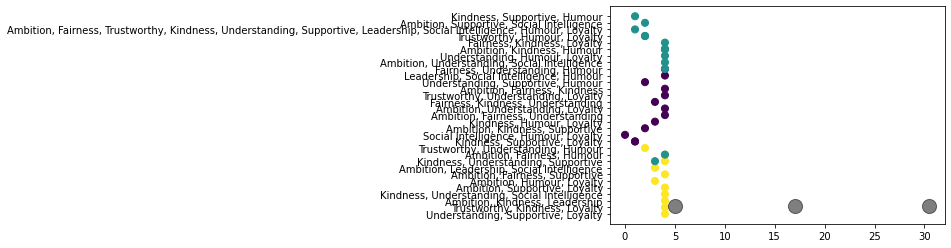

In [30]:
# IGNORE
kmeans = KMeans(n_clusters=3)
kmeans.fit(new_df)
y_kmeans = kmeans.predict(new_df)

plt.scatter(df["year"], df["personal_qualities"], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)